In [61]:
#pandas review
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

order_data = {
    'Order_ID': ['ORD1', 'ORD2', 'ORD3', 'ORD3', 'ORD4', 'ORD5'],
    'User_ID': [101, 102, 101, 101, 103, 104],
    'Price': ['1,000', '5,000', '1,000', '1,000', '3000', '5000'],
    'Date': ['2024-01-01', '2024-01-02', '2024-01-01', '2024-01-01', '2024-01-03', '2024-01-04']
}
user_data = {
    'ID': [101, 102, 103, 105],
    'Team': ['Sales', 'HR', 'Sales', 'Dev'],
    'Age': [30, 25, 200, 28] 
}

df_order = pd.DataFrame(order_data)
df_user = pd.DataFrame(user_data)

In [62]:
#1. 전처리

#중복제거 (주문번호가 같은 전산오류로 판단하여 제거)
df_order = df_order.drop_duplicates()

#가격 숫자로 변환
df_order['Price'] = df_order['Price'].str.replace(',','').astype(int)

#날짜 정규화
    #Date가 날짜가 아닌 문자열로 되어있다. -> 날짜형으로 정규화
df_order['Date'] = pd.to_datetime(df_order['Date'])
print(df_order.info())

#이상치 처리
df_user = df_user[df_user['Age'] < 120]

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Order_ID  5 non-null      object        
 1   User_ID   5 non-null      int64         
 2   Price     5 non-null      int64         
 3   Date      5 non-null      datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 200.0+ bytes
None


In [63]:
#2. 데이터 결합
df_merged = pd.merge(df_order, df_user, left_on = 'User_ID', right_on = 'ID', how = 'left')
    #userID의 이름이 달라 FK지정해줌
df_merged = df_merged.drop(columns = ['ID'])

print(df_merged) #Team과 Age에 NaN존재
#결측치 처리
df_merged['Team'] = df_merged['Team'].fillna('Unknown') #알 수 없는 Team의 정보를 'Unknown'으로 처리
    #Age는 NaN으로 비워둠(지우기엔 정보가 소중함)

  Order_ID  User_ID  Price       Date   Team   Age
0     ORD1      101   1000 2024-01-01  Sales  30.0
1     ORD2      102   5000 2024-01-02     HR  25.0
2     ORD3      101   1000 2024-01-01  Sales  30.0
3     ORD4      103   3000 2024-01-03    NaN   NaN
4     ORD5      104   5000 2024-01-04    NaN   NaN


In [64]:
#3. 그룹화

#AGG : 팀별 (매출 합계, 나이 평균) 구하기
df_agg = df_merged.groupby('Team').agg({
    'Price' : 'sum',
    'Age' : 'mean'
})
print(df_agg) #지금은 Unknown(팀 정보 모름 및 나이 정보 모름)이 전부 데이터가 없어서
                #나이도 NaN으로 나왔지만 원래는 NaN값 빼고 계산해준다.

#TRANS : 팀 평균 매출 컬럼 추가하기
df_merged['Team_avg'] = df_merged.groupby('Team')['Price'].transform('mean')
    #agg는 그룹화 되어 보였지만 transform은 원래 데이터의 행을 유지하기에 원본 + 추가값이 적용
print(df_merged)

#FILTER : 총 매출 2000이상 팀만
df_rich = df_merged.groupby('Team').filter(lambda x : x['Price'].sum() >= 5000)
print(df_rich)

         Price   Age
Team                
HR        5000  25.0
Sales     2000  30.0
Unknown   8000   NaN
  Order_ID  User_ID  Price       Date     Team   Age  Team_avg
0     ORD1      101   1000 2024-01-01    Sales  30.0    1000.0
1     ORD2      102   5000 2024-01-02       HR  25.0    5000.0
2     ORD3      101   1000 2024-01-01    Sales  30.0    1000.0
3     ORD4      103   3000 2024-01-03  Unknown   NaN    4000.0
4     ORD5      104   5000 2024-01-04  Unknown   NaN    4000.0
  Order_ID  User_ID  Price       Date     Team   Age  Team_avg
1     ORD2      102   5000 2024-01-02       HR  25.0    5000.0
3     ORD4      103   3000 2024-01-03  Unknown   NaN    4000.0
4     ORD5      104   5000 2024-01-04  Unknown   NaN    4000.0


In [65]:
#4. 구조 변경
df_pivot = df_merged.pivot_table(
    index = 'Team', #팀을 인덱스로 하고
    columns = 'Date', #날짜를 컬럼으로 잡겠다
    values = 'Price', #원하는 것은 팀의 날짜별 가격이고
    aggfunc = 'sum', #각 가격의 합계를 보겠다
    fill_value = 0 #값이 없는건 0으로 처리하겠다
)
print(df_pivot)

df_melt = df_pivot.reset_index().melt( #피벗한 테이블의 인덱스를 리셋하면서 
    id_vars = 'Team', #Team은 그대로 기둥으로 두고
    var_name = 'Date', #기존 컬럼들을 Date안에 값으로 넣겠다
    value_name = 'Sales' #기존 데이터를 Sales안에 값으로 넣겠다
)
print(df_melt)

Date     2024-01-01  2024-01-02  2024-01-03  2024-01-04
Team                                                   
HR                0        5000           0           0
Sales          2000           0           0           0
Unknown           0           0        3000        5000
       Team                 Date  Sales
0        HR  2024-01-01 00:00:00      0
1     Sales  2024-01-01 00:00:00   2000
2   Unknown  2024-01-01 00:00:00      0
3        HR  2024-01-02 00:00:00   5000
4     Sales  2024-01-02 00:00:00      0
5   Unknown  2024-01-02 00:00:00      0
6        HR  2024-01-03 00:00:00      0
7     Sales  2024-01-03 00:00:00      0
8   Unknown  2024-01-03 00:00:00   3000
9        HR  2024-01-04 00:00:00      0
10    Sales  2024-01-04 00:00:00      0
11  Unknown  2024-01-04 00:00:00   5000


  Order_ID  User_ID  Price       Date     Team   Age  Team_avg
0     ORD1      101   1000 2024-01-01    Sales  30.0    1000.0
1     ORD2      102   5000 2024-01-02       HR  25.0    5000.0
2     ORD3      101   1000 2024-01-01    Sales  30.0    1000.0
3     ORD4      103   3000 2024-01-03  Unknown   NaN    4000.0
4     ORD5      104   5000 2024-01-04  Unknown   NaN    4000.0


C:\Users\bhc02\AppData\Local\Temp\ipykernel_884\2979664702.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_merged.groupby('Team')['Price'].sum().plot(kind='line', title = 'Team Sales')


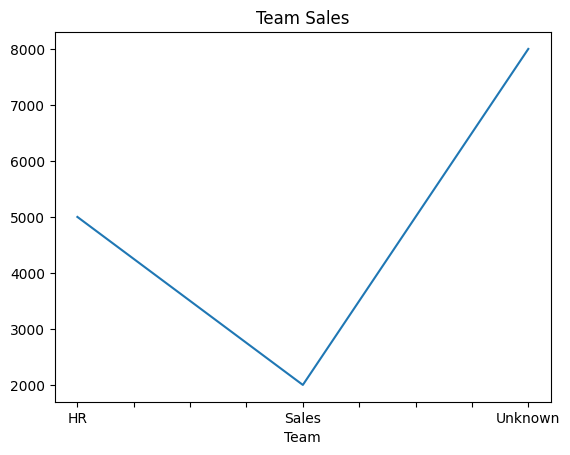

In [ ]:
#5. 최적화, 시각화

#최적화
df_merged['Team'] = df_merged['Team'].astype('category')
print(df_merged) #겉보기엔 같지만 내부처리는 0,1, 등으로 처리하여 가벼워짐

#시각화
df_merged.groupby('Team')['Price'].sum().plot(kind='bar', title = 'Team Sales')
plt.show()

